# Model Building
This notebooks contains the the model building for the first iteration - including model optimization via gridsearch

# Imports

In [1]:
# Necessary to import custom modules
import os
os.chdir("/home/jovyan/work")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Construct data

In [2]:
# read features and drop obsolete ones
df_raw = pd.read_csv("./data/features/first_iteration.csv")

# construct training data
df_train = \
    df_raw[df_raw["season"].isin(["2015/2016", "2016/2017"])]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"]
          + [col for col in df_raw.columns if "2017/2018" in col] , axis=1)
X_train, y_train = df_train.drop(["home_win"], axis=1).values, df_train["home_win"].values

# construct final validation data
df_val = \
    df_raw[df_raw["season"] == "2016/2017"]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"]
          + [col for col in df_raw.columns if "2017/2018" in col] , axis=1)
X_val, y_val = df_val.drop(["home_win"], axis=1).values, df_val["home_win"].values

# Baseline

### Predict always win

In [3]:
log_loss(y_val, np.ones_like(y_val))

14.406881964719725

### Predict always loss

In [4]:
log_loss(y_val, np.zeros_like(y_val))

20.132227952113713

### Predict always draw

In [5]:
log_loss(y_val, np.ones_like(y_val)*.5)

0.69314718055994518

# Logistic Regression

In [6]:
# parameter grid
pg_lr = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1.0, 10],
}

# cross validated estimator
GS_LR = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=pg_lr,
    cv=5,
    n_jobs=-1
)

# model fitting
GS_LR.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_LR.predict_proba(X_val))

0.62111486867417454

# Random Forest

In [7]:
# parameter grid
param_grid = {
    "n_estimators": [10, 25, 50, 100, 250]
}

# cross validated estimator
GS_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring="neg_log_loss"
)

# model fitting
GS_RF.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_RF.predict_proba(X_val))

0.40694127566278399

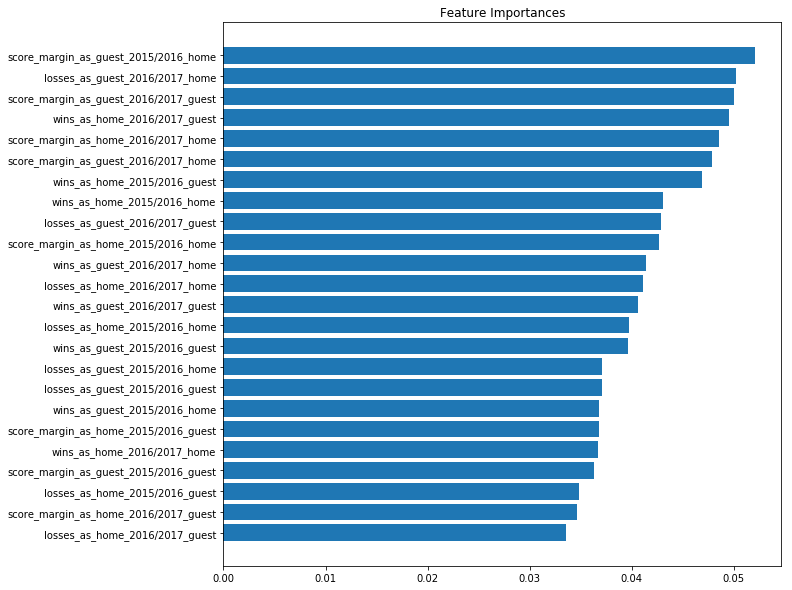

In [10]:
forest = GS_RF.best_estimator_
imps = forest.feature_importances_
idx = np.argsort(imps)
cols = df_train.drop(["home_win"], axis=1).columns[idx]

plt.barh(range(len(imps)), imps[idx])
plt.yticks(range(len(imps)), cols[idx])
plt.title("Feature Importances");